In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats, signal, optimize
from tqdm import tqdm
import pandas as pd

import os, sys
rootpath = os.path.join(os.getcwd(), '.')
sys.path.append(rootpath)
from src.analysis import *
from src.theory import *
# reimport modules if they change
%load_ext autoreload
%autoreload 2

# Global parameters

In [2]:
# specify system parameters
params = {
    'N': 10000, # number of nodes
    'K': 100, # number of connections per node
    'mu': 0.2, # fraction of nodes that receive input
    'sigma': 0.01, # std of additive Gaussian noise
    'epsilon': 0.1, # error threshold for overlap
}

# Analytic solution for $T\to\infty$
For the $T\to\infty$ case, we have a one-to-one mapping between input $h$ and network activity $a$, given by 
$$a(h|\lambda, \mu) = \frac{\mu\left(1-e^{-h\Delta t}\right)}{1-\lambda(1-\mu)-\lambda\mu e^{-h\Delta t}}$$

In [3]:
mean_field_activity?

Signature: mean_field_activity(lam, mu, h, dt=1)
Docstring: <no docstring>
File:      /data.nst/johannes/projects/sahel_finite-observation-dynamic-range/0_update/src/theory.py
Type:      function

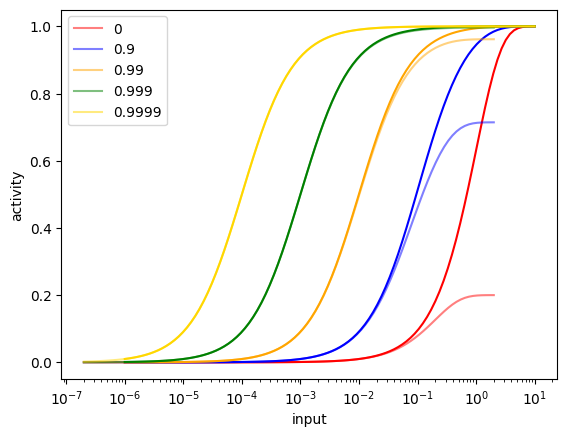

In [7]:
hs=np.logspace(-6,1,100)
colors=['red','blue','orange','green', 'gold']
for i,lam in enumerate([0,0.9,0.99,0.999, 0.9999]):
    plt.plot(hs*0.2, mean_field_activity(lam, params['mu'], hs), label='{}'.format(lam), color=colors[i], alpha=0.5)
    plt.plot(hs, mean_field_activity(lam, 1.0, hs), color=colors[i])
plt.xscale("log")
plt.xlabel("input")
plt.ylabel("activity")
plt.legend()

## Discriminable Intervals (raw)

[1.3152705591323866e-05, 2.7016106502754786e-05, 4.1649550785640885e-05, 5.711904427145929e-05, 7.349812453834629e-05, 9.08696195030545e-05, 0.00010932669546989648, 0.00012897399399719597, 0.0001499306907812005, 0.0001723324141183695, 0.00019633356127083716, 0.00022211188146187708, 0.0002498726254389868, 0.00027985333452363215, 0.00031233130129881576, 0.00034763245493126514, 0.0003861415396767748, 0.0004283162262325502, 0.0004747065201754203, 0.0005259779824483926, 0.0005829428013241289, 0.0006466056898101807, 0.0007182225372509726, 0.0007993816063792311, 0.0008921269045112833, 0.0009991313174147762, 0.001123955363254409, 0.00127145480466628, 0.0014484275776869867, 0.0016646869164144665, 0.0019349463147948754, 0.0022823207970617833, 0.002745309221791356, 0.003393142404071527, 0.0043641379302381544, 0.005980474083127359, 0.009205617319726946]
[0.01881407143322633, 0.009203729909484327, 0.005979627748355973, 0.0043636648456649415, 0.0033928405444843468, 0.002745098631712415, 0.0022821647

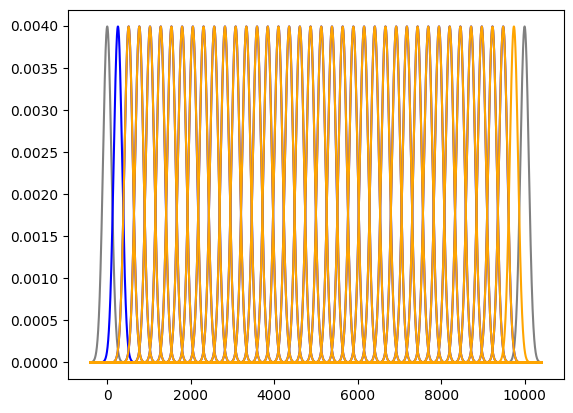

In [9]:
# test discriminable intervals
lam = 0.9999
Xs = np.arange(-4*params['sigma']*params['N'],params['N']+4*params['sigma']*params['N'])

def pmf(h):
    # see below for formal derivation, here just as a test
    A = mean_field_activity(lam, params['mu'], h)*params['N']
    # in domain with delta = 1
    delta = 1
    return stats.norm.pdf(Xs, A, params['sigma']*params['N'])*delta

h_range=[0,1e3]
pmf_ref_left = pmf(h_range[0])
pmf_ref_right = pmf(h_range[1])

plt.plot(Xs,pmf_ref_left, color="gray")
plt.plot(Xs,pmf_ref_right, color="gray")

hs_left = find_discriminable_inputs(pmf, h_range, [pmf_ref_left, pmf_ref_right], params['epsilon'], start="left")
print(hs_left)
for h in hs_left:
    plt.plot(Xs,pmf(h), color="blue")

hs_right = find_discriminable_inputs(pmf,h_range, [pmf_ref_left, pmf_ref_right], params['epsilon'], start="right")
print(hs_right)
for h in hs_right:
    plt.plot(Xs,pmf(h), color="orange")
#plt.legend()

## Convolution of network output with Gaussian noise
The output of the network is the sum of the network activity and Gaussian noise $\eta\sim\mathcal{N}(0,1)$ such that 
$$ o = a + \sigma\eta $$
The output is thus a convolution between $P(a)$ and $\mathcal{N}(0,\sigma)$.

For $T\to\infty$ the distribution of activity is a delta-distribution such that the the output distribution becomes a shifted Gaussian
$$ P(o) = \mathcal{N}(a(h|\lambda,\mu), \sigma)$$

In [10]:
# set resolution of lambdas
lams_inf = 1 - np.logspace(-4, 0, 30)

In [12]:
# iterate over lambdas and calculate dr, and nds; save in textfile for plotting
# if textfile exists, load it  
N,K,mu,sigma,epsilon = params.values()
flag_compute_inf = True
if os.path.isfile("dat/results_inf.txt"):
    data = np.loadtxt("dat/results_inf.txt")
    lams_inf_ = data[:, 0]
    drs_inf = data[:, 1]
    nds_inf = data[:, 2]
    if np.array_equal(lams_inf_, lams_inf):
        flag_compute_inf = False
        print("Loading data from dat/results_inf.txt")
    else:
        print("lams_inf not as specified, recomputing")

if flag_compute_inf:
    Xs = np.arange(-4 * sigma * N, N + 4 * sigma * N)

    # analysis parameters
    drs_inf = np.zeros(len(lams_inf))
    nds_inf = np.zeros(len(lams_inf))
    h_range = [0, 1e1]

    for i, lam in tqdm(enumerate(lams_inf), total=len(lams_inf)):
        # distribution of noisy output
        def pmf_o_given_h(h):
            A = mean_field_activity(lam, mu, h) * N
            return stats.norm.pdf(Xs, A, sigma * N)

        pmf_ref_left = pmf_o_given_h(h_range[0])
        pmf_ref_right = pmf_o_given_h(h_range[1])
        hs_left = find_discriminable_inputs(pmf_o_given_h, h_range, [pmf_ref_left, pmf_ref_right], epsilon, verbose=False)
        hs_right = find_discriminable_inputs(pmf_o_given_h, h_range, [pmf_ref_left, pmf_ref_right], epsilon, start="right")
        drs_inf[i] = dynamic_range((hs_left[0], hs_right[0]))
        nds_inf[i] = 0.5 * (len(hs_left) + len(hs_right))

    # save data
    np.savetxt("dat/results_inf.txt", np.transpose([lams_inf, drs_inf, nds_inf]))


100%|██████████| 30/30 [00:43<00:00,  1.44s/it]


## Load analysed data

In [6]:
import sqlite3
con = sqlite3.connect('simulations.db')
cur = con.cursor()
# load dataframe from table
results = pd.read_sql_query(f"SELECT * FROM results WHERE N={params['N']} AND K={params['K']} AND mu={params['mu']} AND sigma={params['sigma']} AND epsilon={params['epsilon']}", con)
results.drop(columns=['N', 'K', 'mu', 'sigma', 'epsilon'], inplace=True)
con.close()

results

,seed,window,filename
0,1001,0.000001,/data.nst/johannes/projects/sahel_finite-obser...
1,1001,1.000000,/data.nst/johannes/projects/sahel_finite-obser...
2,1001,10.000000,/data.nst/johannes/projects/sahel_finite-obser...
3,1001,100.000000,/data.nst/johannes/projects/sahel_finite-obser...
4,1001,1000.000000,/data.nst/johannes/projects/sahel_finite-obser...
5,1001,10000.000000,/data.nst/johannes/projects/sahel_finite-obser...


## Make plot for selected N,K,mu

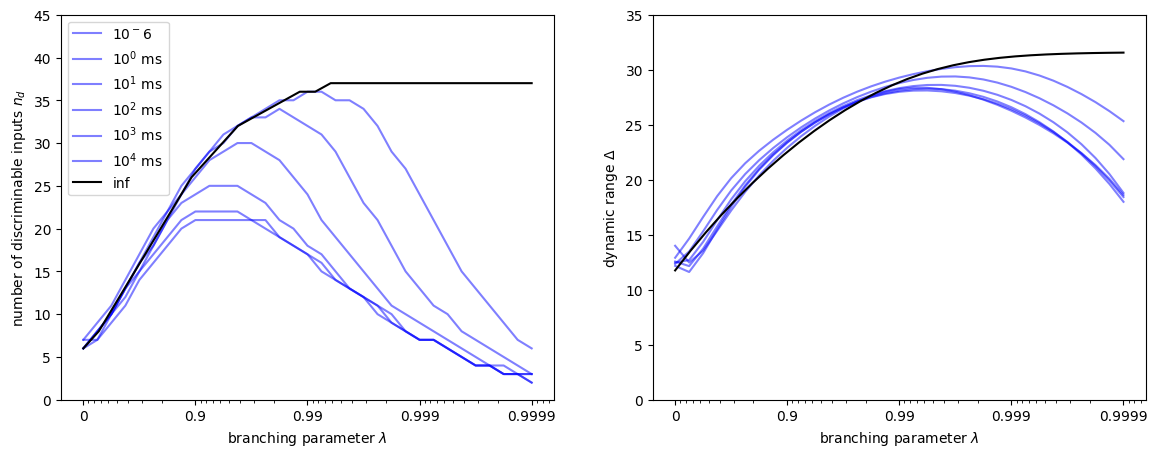

In [16]:
# plot the number of discriminable inputs for different values of epsilon and T in a main plot with an inset
markers = ["x", "o", "s", "^", "P", "d"]
legends = ["$10^-6$", "$10^0$ ms", "$10^1$ ms", "$10^2$ ms", "$10^3$ ms", "$10^4$ ms"]

fig, ax = plt.subplots(1, 2, figsize=(14, 5))
for (i,window) in enumerate(results["window"].unique()):
    # reduce dataframe to current window
    sel = results[results["window"] == window]
    for (s, seed) in enumerate(sel.seed.unique()):
        # load file
        filename = results[(results["window"] == window) & (results["seed"] == seed)].filename.values[0]
        lams_data, nds_data, drs_data = np.loadtxt(f"{filename}", skiprows=1, unpack=True)
        ax[0].plot(1-lams_data, nds_data, label=legends[i], color="blue", alpha=0.5)
        ax[1].plot(1-lams_data, drs_data, label=legends[i], color="blue", alpha=0.5)
ax[0].plot(1 - lams_inf, nds_inf, label="inf", color="black")
ax[0].set_xlabel("branching parameter $\lambda$")
ax[0].set_ylim(0, 45)
ax[0].set_ylabel("number of discriminable inputs $n_d$")
ax[0].set_xscale("log")
ax[0].set_xticks([1e-4, 1e-3, 1e-2, 1e-1, 1e0])
ax[0].set_xticklabels(["0.9999", "0.999", "0.99", "0.9", "0"])
ax[0].invert_xaxis()
ax[1].plot(1 - lams_inf, drs_inf, label="inf", color="black")
ax[1].set_xlabel("branching parameter $\lambda$")
ax[1].set_ylim(0, 35)
ax[1].set_ylabel("dynamic range $\Delta$")
ax[1].set_xscale("log")
ax[1].set_xticks([1e-4, 1e-3, 1e-2, 1e-1, 1e0])
ax[1].set_xticklabels(["0.9999", "0.999", "0.99", "0.9", "0"])
ax[1].invert_xaxis()
ax[0].legend(loc='upper left')

## TODO:
- Develop an approximation to the finite-time solution as a correction to the infinite T limit?
- Fit this?
- Or take absolute maximum? -> as inset?
- Only Fig n_d and DR ... Lets try to replot with development of maxima as inset
